This is a Pytorch implimentation of the Conditional General Adivisary Network as stated in https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/03_CGAN_CIFAR10.ipynb

In [1]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     / 409kB 1.8MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=5144197cfd91dbff1f86a489751e1f1b03058013fa62aaaf12569ed283a45211
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbh1h137/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [14]:
# save weights

from google.colab import drive
drive.mount("/content/gdrive")

def save_model(model, name):
    torch.save(model.state_dict(), f'/content/gdrive/My Drive/Project:GAN/Deep_Vision_Project/weights/CGAN/{name}.ckpt')

def load_generator(name):
    model = Generator()
    model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Project:GAN/Deep_Vision_Project/weights/CGAN/{name}.ckpt', map_location=torch.device('cpu')))
    #if use_gpu:
    #    model = model.cuda()
    
    return model

def load_discriminator(name):
    model = Discriminator()
    model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Project:GAN/Deep_Vision_Project/weights/CGAN/{name}.ckpt', map_location=torch.device('cpu')))
    #if use_gpu:
    #    model = model.cuda()
    
    return model    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
BETA1 = 0.5
NUM_EPOCHS = 20
NUM_CLASSES = 10
BATCH_SIZE = 100
NOISE_SIZE = 100 

SMOOTHNESS = 0.1

In [6]:
# load data
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transforms.ToTensor())
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)

dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True)

[============================================================] 1/1

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
print(dataset_train)
print(dataset_test)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


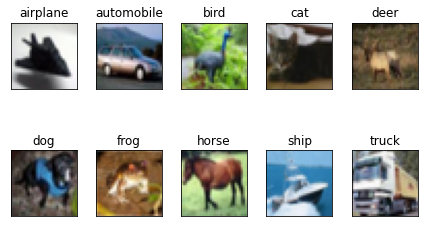

In [8]:
# work with data
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

for i in range(10):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    for j in range(50000):
        if dataset_train[j][1] == i:
            idx = j
            break
    img = F.to_pil_image(dataset_train[idx][0])
    ax.set_title(class_names[i])
    #print(img)
    plt.imshow(img)
plt.tight_layout()

In [9]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features = NOISE_SIZE + 10 , out_features= 512 *2*2),
            torch.nn.BatchNorm1d(2048, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        
        self.ReLU = torch.nn.ReLU()
        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 512 , out_channels= 256, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(256,momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 256, out_channels= 128, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(128, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 128, out_channels= 64, kernel_size=5, stride=2, padding=2, output_padding= 1),
            torch.nn.BatchNorm2d(64, momentum =  0.9),
            torch.nn.LeakyReLU(0.1)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels= 64, out_channels= 3, kernel_size=5, stride=2, padding=2, output_padding= 1),
        )

    def forward(self, noise, labels):
        """
        noise has shape (BATCHSIZE, 1)
        labels has shape (BATCHSIZE,)
        """
        
        labels = torch.nn.functional.one_hot(labels, num_classes = 10) #shape (BATCH_SIZE, 10)
        temp = torch.cat((noise, labels.float()), 1) #shape (BATCH_SIZE, NOISE_SIZE)
        temp = self.dense(temp) #shape (BATCH_SIZE, 2048)
        #temp = self.ReLU(temp)
        
        temp = torch.reshape(temp, (-1, 512,2,2))  # shape (BATCH_SIZE, 512,2,2)
        temp = self.conv1(temp) # shape (BATCH_SIZE, 256, 4, 4)
        temp = self.conv2(temp) # shape (BATCH_SIZE, 128, 8, 8)
        temp = self.conv3(temp) # shape (BATCH_SIZE, 64, 16, 16)
        temp = self.conv4(temp) # shape (BATCH_SIZE, 3, 32, 32)
        
        return torch.tanh(temp)
        
    
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # TO DO : padding should be same
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=5, stride= 2, padding=2),
            torch.nn.BatchNorm2d(64,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(128,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 128, out_channels= 256, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(256, momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 256, out_channels= 512, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(512,momentum= 0.9),
            torch.nn.LeakyReLU(negative_slope=0.1)
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.fully_connected = torch.nn.Sequential(
            torch.nn.Linear(2058, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )
        
        
    def forward(self, images, labels):
        
        temp = self.conv1(images)
        temp = self.conv2(temp)
        temp = self.conv3(temp)
        temp = self.conv4(temp)
        
        temp = self.flatten(temp)
        
        
        # bring label in right form and add as dimention
        temp_labels = torch.nn.functional.one_hot(labels, num_classes = 10)
        temp = torch.cat([temp, temp_labels.float()], 1)
        
        temp = self.fully_connected(temp)
        return temp
        

In [10]:
#opt

real_label = 1
false_label = 0

Gen = Generator()
Disc = Discriminator()

opt_gen = torch.optim.Adam(Gen.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
opt_disc = torch.optim.Adam(Disc.parameters(), lr = 0.0002, betas = (BETA1, 0.999))
loss = torch.nn.BCELoss()

In [11]:
Gen = load_generator("generator")
Disc = load_discriminator("discriminator")

Gen = Gen.cuda()
Disc = Disc.cuda()

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


epoch: 0


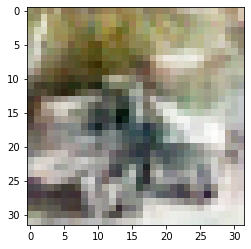

label: cat
D-Loss is 0.20641553401947021 and G-Loss is 12.539216041564941


epoch: 1
D-Loss is 0.16856320202350616 and G-Loss is 14.380349159240723


epoch: 2
D-Loss is 0.16972540318965912 and G-Loss is 10.806768417358398


epoch: 3
D-Loss is 0.17325371503829956 and G-Loss is 12.183769226074219


epoch: 4
D-Loss is 0.18017180263996124 and G-Loss is 13.12368392944336


epoch: 5


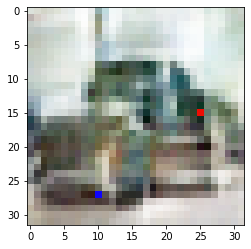

label: bird
D-Loss is 0.17990444600582123 and G-Loss is 12.157790184020996


epoch: 6
D-Loss is 0.17847944796085358 and G-Loss is 9.817947387695312


epoch: 7
D-Loss is 0.1841607540845871 and G-Loss is 13.604411125183105


epoch: 8
D-Loss is 0.1701989322900772 and G-Loss is 13.7651948928833


epoch: 9
D-Loss is 0.17026571929454803 and G-Loss is 13.503341674804688


epoch: 10


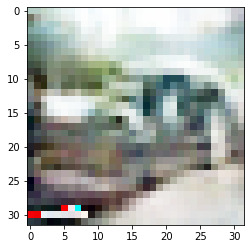

label: frog
D-Loss is 0.16825875639915466 and G-Loss is 17.538793563842773


epoch: 11
D-Loss is 0.17171521484851837 and G-Loss is 15.064457893371582


epoch: 12
D-Loss is 0.17265832424163818 and G-Loss is 11.128928184509277


epoch: 13
D-Loss is 0.16976593434810638 and G-Loss is 13.689655303955078


epoch: 14
D-Loss is 0.17002882063388824 and G-Loss is 13.136354446411133


epoch: 15


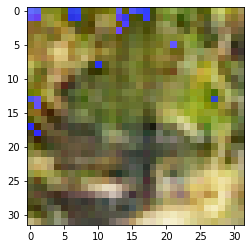

label: ship
D-Loss is 0.1715492606163025 and G-Loss is 8.965791702270508


epoch: 16
D-Loss is 0.2130686193704605 and G-Loss is 15.788066864013672


epoch: 17
D-Loss is 0.1790948063135147 and G-Loss is 12.48503303527832


epoch: 18
D-Loss is 0.1727103888988495 and G-Loss is 10.159476280212402


epoch: 19
D-Loss is 0.17301571369171143 and G-Loss is 13.601398468017578


In [12]:
# training
i = 0
for epoch in tqdm(range(NUM_EPOCHS)):
    for image, category in tqdm(data_loader_train):
        image = image.cuda()
        category = category.cuda()

        # train Discriminator--------------------------------------
        opt_disc.zero_grad()
        
        # train with true pictures -----
        output = Disc(image, category)
        
        label = torch.full(size = (BATCH_SIZE,1), fill_value = real_label * (1- SMOOTHNESS))
        label = label.cuda()
        disc_loss_real = loss(output, label)
        #disc_loss_real.backward()
        
        #train with generated pictures -----
        
        #generate input from Generator
        # noise is taken from N(0,1) distribution
        noise = torch.randn(size = (BATCH_SIZE, NOISE_SIZE))
        noise = noise.cuda()
        gen_categories = torch.randint(low = 0, high = 10, size = (BATCH_SIZE,))
        gen_categories = gen_categories.cuda()
        inp = Gen(noise, gen_categories)
        
        output = Disc(inp.detach(), gen_categories)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = false_label)
        label = label.cuda()
        disc_loss_false = loss(output, label)
        #disc_loss_false.backward()
        
        disc_loss = 0.5 * (disc_loss_false + disc_loss_real)
        disc_loss.backward()
        opt_disc.step()
        
        # train Generator--------------------------------------
        opt_gen.zero_grad()
        #we don't calculate noise and gen_categories twice, inp stays the same
        # we updated Disc so we calculate it again
        output = Disc(inp, category)
        
        label = torch.full(size = (BATCH_SIZE, 1), fill_value = real_label)
        label = label.cuda()
        # we calculate the difference to the real label
        
        batch_loss = loss(output, label)
        batch_loss.backward()
        opt_gen.step()
        
    print("epoch: " + str(epoch))
    if epoch %5 == 0:
        inp = inp.cpu()
        Img = F.to_pil_image(inp[0])
        plt.imshow(Img)
        plt.show()
        print("label: " + class_names[gen_categories[0].item()])
    print("D-Loss is " + str(disc_loss.item()) + " and G-Loss is " + str(batch_loss.item()))
        

In [15]:
save_model(Gen, "generator")
save_model(Disc, "discriminator")